# Using Kaggle dataset: classification of cataract presence in human eyes

Cataracts have several stages. Here we analyze the difference between immature and mature cataract. At the immature stage, the lens of an eye is clouded and prescription glassses are usually recommended.

At the mature stage the eye looks noticeable different (milky filter). At this point a surgery is required.

It is now quite obvious that it's vital for a patient to get a correct diagnosis. This notebook presents a binary classification between mature and immature cataract.

I decided to employ three convolutional layers, with very good results.

In [ ]:
import pandas as pd
import numpy as np
import itertools
from PIL import Image


import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Keras libraries:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adamax, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Activation
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.callbacks import EarlyStopping

from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(1)


In [ ]:
pip install opendatasets

In [ ]:
import opendatasets as od

In [ ]:
import os

In [ ]:
od.download(
"https://www.kaggle.com/datasets/akshayramakrishnan28/cataract-classification-dataset", force = True)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: elzbietapolak
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/akshayramakrishnan28/cataract-classification-dataset


100%|██████████| 18.9M/18.9M [00:00<00:00, 78.3MB/s]


In [ ]:
data_dir = '/content/cataract-classification-dataset/train'

In [ ]:
imagepaths = [] # paths to every image
labels =[] # either mature or immature

for folder in os.listdir(data_dir):
  folderpath = os.path.join(data_dir, folder)
  folderlist = os.listdir(folderpath)

  for file in folderlist:
    image = os.path.join(folderpath,file)
    imagepaths.append(image)
    labels.append(folder)


In [ ]:
# Creating a dataframe:

Imageseries = pd.Series(imagepaths, name= 'imagepaths')
Labelseries = pd.Series(labels, name='labels')
df = pd.concat([Imageseries, Labelseries], axis= 1)

In [ ]:
df.head()

,imagepaths,labels
0,/content/cataract-classification-dataset/train...,immature
1,/content/cataract-classification-dataset/train...,immature
2,/content/cataract-classification-dataset/train...,immature
3,/content/cataract-classification-dataset/train...,immature
4,/content/cataract-classification-dataset/train...,immature


In [ ]:
df.labels.value_counts()

labels
immature    214
mature      196
Name: count, dtype: int64

In [ ]:
# The numbers of cases are non even so we need to stratify:

train, test = train_test_split(df, train_size = 0.8, shuffle = True, random_state = 14, stratify = df.labels)

In [ ]:
train.head()

,imagepaths,labels
305,/content/cataract-classification-dataset/train...,mature
31,/content/cataract-classification-dataset/train...,immature
287,/content/cataract-classification-dataset/train...,mature
91,/content/cataract-classification-dataset/train...,immature
368,/content/cataract-classification-dataset/train...,mature


In [ ]:
train.shape

(328, 2)

In [ ]:
# Input parameters:

img_size = (416, 416)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

In [ ]:
# Data augmentation step, since the training set is pretty small:

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
training_set = train_datagen.flow_from_dataframe(train, x_col= 'imagepaths', y_col= 'labels', target_size= img_size,
                                    color_mode= 'rgb', shuffle= True,
                                                 class_mode = 'categorical', batch_size = 8)

Found 328 validated image filenames belonging to 2 classes.


In [ ]:
# Preprocessing the test set:

test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_dataframe(test, x_col= 'imagepaths', y_col= 'labels', target_size= img_size,
                                    color_mode= 'rgb', shuffle= False,
                                                 class_mode = 'categorical', batch_size = 8)

Found 82 validated image filenames belonging to 2 classes.


In [ ]:
# Defining the dictionary for binary classification:

dict_ = training_set.class_indices
classes = list(dict_.keys())
images, labels = next(training_set)

In [ ]:
classes

['immature', 'mature']

In [ ]:
dict_

{'immature': 0, 'mature': 1}

 Plotting some photos to get a difference between mature and immature cataract:

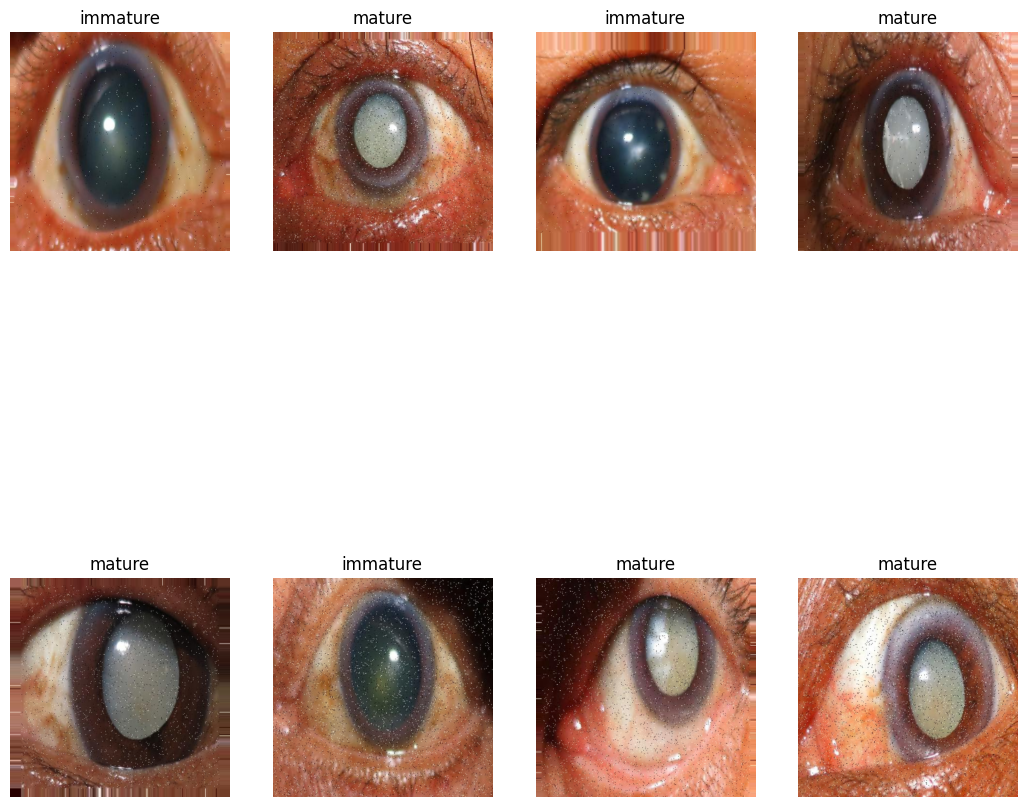

In [ ]:
plt.figure(figsize= (13, 13))

for i in range(8):
    plt.subplot(2, 4, i + 1)
    image = images[i]
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, fontsize= 12)
    plt.axis('off')
plt.show()

In [ ]:
# Defining the number of classes in the last dense layer:

classes_number = len(list(training_set.class_indices.keys()))


In [ ]:
cnn = tf.keras.models.Sequential()

In [ ]:
# Building the model with three convolutional layers:

cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(416, 416,3)))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))
cnn.add(tf.keras.layers.Dense(units=classes_number, activation='sigmoid'))

In [ ]:
# Compiling the model:

cnn.compile(Adam(learning_rate= 0.001), loss= 'binary_crossentropy', metrics= ['accuracy'])

cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_100 (Conv2D)         (None, 414, 414, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 207, 207, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_101 (Conv2D)         (None, 205, 205, 32)      9248      
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 102, 102, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_102 (Conv2D)         (None, 100, 100, 32)      9248      
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 50, 50, 32)       

In [ ]:
# Training the model:
# Using early stopping, in case the loss doesn't improve:

callback = keras.callbacks.EarlyStopping(monitor='loss', patience=4)
history = cnn.fit(x = training_set, validation_data = test_set, verbose = 1, epochs = 30, callbacks=[callback])

Epoch 1/30
41/41 [==============================] - 100s 2s/step - loss: 0.7742 - accuracy: 0.6098 - val_loss: 0.4576 - val_accuracy: 0.8049
Epoch 2/30
41/41 [==============================] - 94s 2s/step - loss: 0.4605 - accuracy: 0.7957 - val_loss: 0.3831 - val_accuracy: 0.8415
Epoch 3/30
41/41 [==============================] - 98s 2s/step - loss: 0.3287 - accuracy: 0.8720 - val_loss: 0.2937 - val_accuracy: 0.8415
Epoch 4/30
41/41 [==============================] - 98s 2s/step - loss: 0.3108 - accuracy: 0.8720 - val_loss: 0.1726 - val_accuracy: 0.9268
Epoch 5/30
41/41 [==============================] - 96s 2s/step - loss: 0.2411 - accuracy: 0.9116 - val_loss: 0.2099 - val_accuracy: 0.9390
Epoch 6/30
41/41 [==============================] - 97s 2s/step - loss: 0.2519 - accuracy: 0.9268 - val_loss: 0.1550 - val_accuracy: 0.9512
Epoch 7/30
41/41 [==============================] - 92s 2s/step - loss: 0.1613 - accuracy: 0.9512 - val_loss: 0.1056 - val_accuracy: 0.9634
Epoch 8/30
41/41 [=

# Metrics for the model: loss, validation loss, accuracy and confusion matrix

Plotting accuracy, and loss on the training and validation sets:

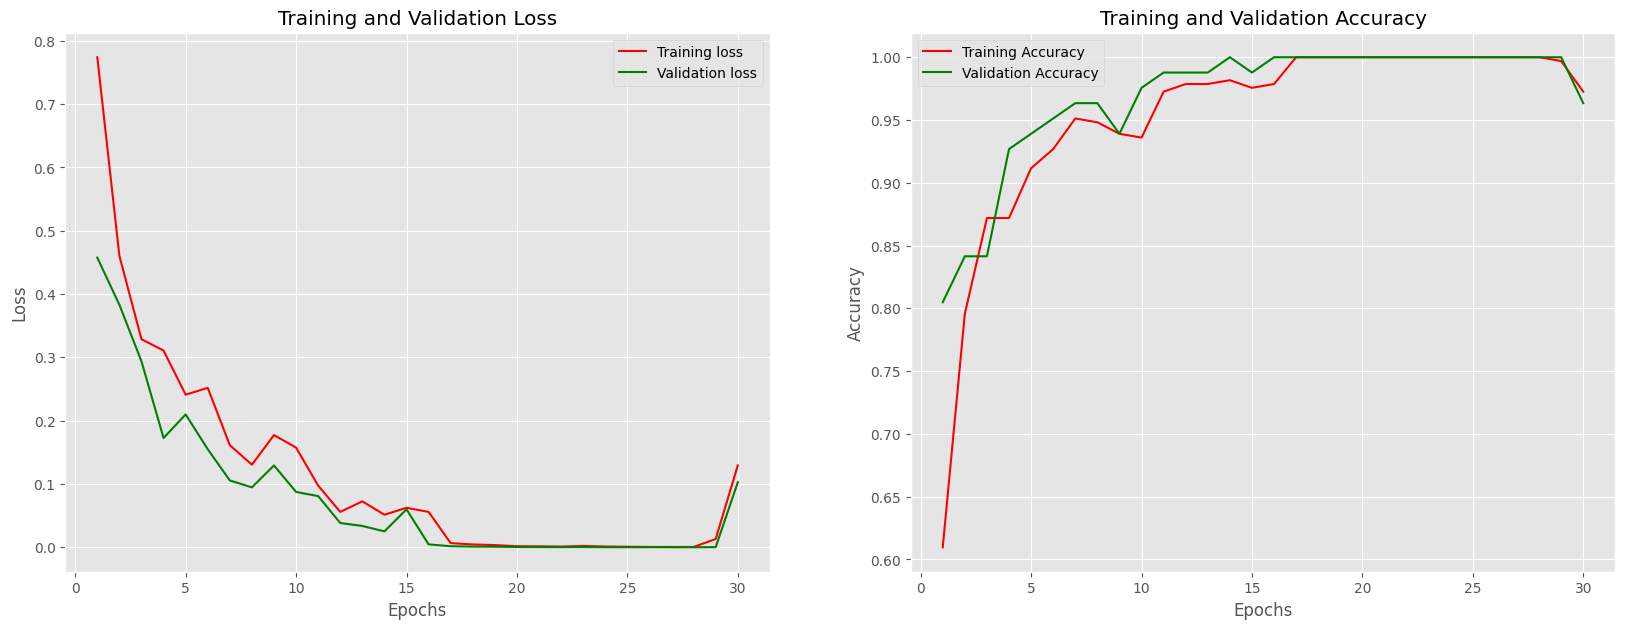

In [ ]:
# Defining variables for plotting:

training_acc = history.history['accuracy']
training_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
Epochs = [i+1 for i in range(len(training_acc))]

# Plotting training history:

plt.figure(figsize= (20, 7))
plt.style.use('ggplot')

# Left plot: training and validation loss:

plt.subplot(1, 2, 1)
plt.plot(Epochs, training_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Right plot: training and validation accuracy:

plt.subplot(1, 2, 2)
plt.plot(Epochs, training_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

Predicting new results:

In [ ]:
preds = cnn.predict(test_set)
y_pred = np.argmax(preds, axis=1)

11/11 [==============================] - 5s 411ms/step


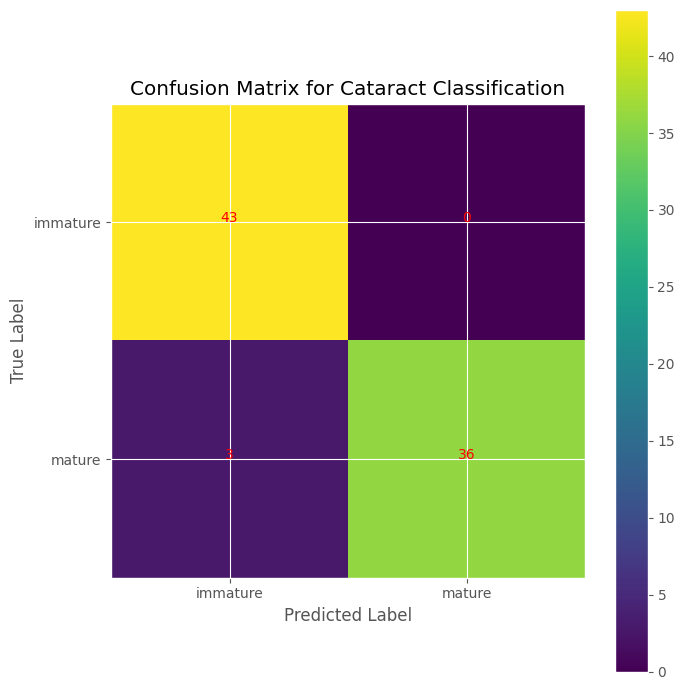

In [ ]:
new_dict = test_set.class_indices
classes = list(new_dict.keys())

# Confusion matrix:

cm = confusion_matrix(test_set.classes, y_pred)

plt.figure(figsize= (7, 7))
plt.imshow(cm, interpolation= 'nearest')
plt.title('Confusion Matrix for Cataract Classification')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment = 'center', color= 'red')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
# Classification report
print(classification_report(test_set.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

    immature       0.93      1.00      0.97        43
      mature       1.00      0.92      0.96        39

    accuracy                           0.96        82
   macro avg       0.97      0.96      0.96        82
weighted avg       0.97      0.96      0.96        82

